In [1]:
# Setup
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torchsummary import summary
from PIL import Image
import spline
from torch.utils.data import TensorDataset, DataLoader

import os



In [2]:

# This is just a copy of Conv implementation from the deep learning lab, wanted to test how fast it trained when using custom implementation
class Conv2d(nn.Module):
    """
    2D convolutional layer.
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(Conv2dd, self).__init__()
        
        """
        Initialize the layer with given params

        Args:
            in_channels: # channels that the input has.
            out_channels: # channels that the output will have.
            kernel_size: height and width of the kernel in pixels.
            stride: # pixels between adjacent receptive fields in both
                horizontal and vertical.
            padding: # pixels that is used to zero-pad the input.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        ########################################################################
        #        TODO: Create place holder tensors for weight and bias         #
        #                       with correct dimensions.                       #
        ########################################################################

        self.weight = torch.Tensor(out_channels,
                                   in_channels,
                                   kernel_size,
                                   kernel_size)
        self.bias = torch.Tensor(out_channels)

        ########################################################################
        #                         END OF YOUR CODE                             #
        ########################################################################

        # Initialize parameters
        self.init_params()


    def init_params(self, std=0.7071):
        """
        Initialize layer parameters. Sample weight from Gaussian distribution
        and bias will be zeros.

        Args:
            std: Standard deviation of Gaussian distribution (default: 0.7071)
        """

        self.weight = std * torch.randn_like(self.weight)
        self.bias = torch.rand_like(self.bias)

    def forward(self, x):
        # Calculate output dimensions
        N, _, H, W = x.shape
        Hp = (H + 2 * self.padding - self.kernel_size) // self.stride + 1
        Wp = (W + 2 * self.padding - self.kernel_size) // self.stride + 1

        # Use unfold to extract sliding windows
        x_unfolded = F.unfold(x, kernel_size=self.kernel_size, dilation=1, padding=self.padding, stride=self.stride)
        x_unfolded = x_unfolded.transpose(1, 2).reshape(N, Hp * Wp, self.in_channels, self.kernel_size, self.kernel_size)

        # Perform the custom operation for each output channel
        output = torch.zeros(N, self.out_channels, Hp, Wp, device=x.device)
        for c in range(self.out_channels):
            # Apply your custom function - modify as necessary to use batch processing
            temp = x_unfolded.reshape(N * Hp * Wp, -1).t()  # Flatten and transpose for batch processing
            spline_values = spline.coef2curve(temp, self.knots[c], self.coeff[c], self.degree)
            output[:, c, :, :] = spline_values.sum(dim=0).view(N, Hp, Wp)

        return output

    def backward(self, dupstream):
        """
        Backward pass of convolutional layer: calculate gradients of loss with
        respect to weight and bias and return downstream gradient dx.

        Args:
            dupstream: Gradient of loss with respect to output of this layer.

        Returns:
            dx: Gradient of loss with respect to input of this layer.
        """

        # You don't need to implement the backward pass. Instead we give it to
        # you the solution.

        # Unpack cache
        x_padded = self.cache

        # Create an empty dx tensor to accumulate the gradients on. Keep in mind
        # that it has a size according to padded input
        dx_padded = torch.zeros_like(x_padded)

        # Also initialize the weight gradients as zeros
        self.weight_grad = torch.zeros_like(self.weight)

        # Unpack needed dimensions
        N, _, Hp, Wp = dupstream.shape

        # Loop through dupstream
        for i in range(Hp):
            for j in range(Wp):

                # Calculate offset for current window on input
                h_offset = i * self.stride
                w_offset = j * self.stride

                # Get current window of input and gradient of the input
                window = x_padded[:, :, h_offset:h_offset+self.kernel_size, w_offset:w_offset+self.kernel_size]
                dwindow = dx_padded[:, :, h_offset:h_offset+self.kernel_size, w_offset:w_offset+self.kernel_size]

                # Walk through each sample of the input and accumulate gradients
                # of both input and weight
                for k in range(N):
                    dwindow[k] += (self.weight * dupstream[k, :, i, j].view(-1, 1, 1, 1)).sum(dim=0)
                    self.weight_grad += window[k].view(1, self.in_channels, self.kernel_size, self.kernel_size) * dupstream[k, :, i, j].view(-1, 1, 1, 1)
        # Calculate actual size of input height and width
        H = x_padded.shape[2] - 2 * self.padding
        W = x_padded.shape[3] - 2 * self.padding

        # Unpad dx
        dx = dx_padded[:, :, self.padding:self.padding+H, self.padding:self.padding+W]

        # Calculate bias gradients
        self.bias_grad = dupstream.sum(dim=(0, 2, 3))

        return dx

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# Main implementation of CKAN
class CKAN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, grid, stride=1, padding=0, degree=3, grid_range=[-0.5, 3], device='cpu'):
        super(CKAN, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.degree = degree
        self.grid_range = grid_range
        self.device = device
        
        # Knots will have shape (out_channels,  in_channels * kernel_size * kernel_size, grid+1)
        knots = torch.linspace(grid_range[0], grid_range[1], steps=grid + 1, device=device).view(1, 1, -1)
        knots = knots.repeat(out_channels, in_channels * kernel_size * kernel_size, 1)
        self.knots = nn.Parameter(knots, requires_grad=False)
        # Coeff will have shape (out_channels,  in_channels * kernel_size * kernel_size, grid+degree)
        self.coeff = nn.Parameter(0.1 * torch.randn(out_channels, in_channels * kernel_size * kernel_size, grid + degree, device=device), requires_grad=True)

    def forward(self, x):
        N, _, H, W = x.shape
        x_padded = F.pad(x, [self.padding, self.padding, self.padding, self.padding])

        # Unfold to get all sliding windows - Shape becomes  (N, C*K*K, L) where L is the number of extracted windows
        unfolded = F.unfold(x_padded, kernel_size=self.kernel_size, stride=self.stride, padding=0)
        
        unfolded = unfolded.transpose(1, 2).reshape(N, -1, self.in_channels, self.kernel_size, self.kernel_size)

        # Prepare unfolded for batch processing in coef2curve - Final shape becomes (C*K*K, N * L)
        unfolded = unfolded.reshape(-1, self.in_channels * self.kernel_size * self.kernel_size).t()  # (batch_size*Hp*Wp, features)

    
        
        # Output tensor initialization
        Hp = (H + 2 * self.padding - self.kernel_size) // self.stride + 1
        Wp = (W + 2 * self.padding - self.kernel_size) // self.stride + 1
        output = torch.zeros((N, self.out_channels, Hp, Wp), device=self.device)
        
        

        # Loop through each output channel
        for c in range(self.out_channels):
            # Calculate spline values for all pixels and sum in the first dimension (which has size kernel_size*kernel_size*in_channels)
            spline_values = spline.coef2curve(unfolded, self.knots[c], self.coeff[c], self.degree, device=self.device).sum(dim=0)
            output[:, c, :, :] = spline_values.view(N, Hp, Wp)

        return output


In [9]:
class Net(nn.Module):
    """
    3-layer CNN network with max pooling

    Args:
        in_channels: number of features of the input image ("depth of image")
        hidden_channels: number of hidden features ("depth of convolved images")
        out_features: number of features in output layer
    """

    def __init__(self, in_channels, hidden_channels, out_features):
        super(Net, self).__init__()


        # self.conv1 =  Conv2d(in_channels, hidden_channels[0],
        #                        kernel_size=3,
        #                        padding=1)
        
        self. conv1 = CKAN(in_channels, hidden_channels[0],
                               kernel_size=3,
                               padding=1, grid=13)
        
        # self.relu1 = nn.ReLU()
        # self.max_pool1 = nn.MaxPool2d(2)
        # self.conv2 = nn.Conv2d(hidden_channels[0], hidden_channels[1],
        #                        kernel_size=5,
        #                        padding=2)
        # self.relu2 = nn.ReLU()
        # self.max_pool2 = nn.MaxPool2d(2)
        self.fc = nn.Linear(28*28*in_channels, out_features)

    def forward(self, x):
        # First convolutional layer
        x = self.conv1(x)
        # # Activation function
        # x = self.relu1(x)
        # # Max pool
        # x = self.max_pool1(x)
        # # Second convolutional layer
        # x = self.conv2(x)
        # # Activation function
        # x = self.relu2(x)
        # # Max pool
        # x = self.max_pool2(x)
        # Flatten
        x = x.view(x.size(0), -1)
        # # Fully connected layer
        x = self.fc(x)
        return x

In [5]:
# Preprocessing data: convert to tensors and normalize by subtracting dataset
# mean and dividing by std.
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

# Get data from torchvision.datasets
train_data = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('./data', train=False, download=True, transform=transform)

# Define data loaders used to iterate through dataset
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000)

In [6]:
def evaluate_accuracy(data_loader, net, device=torch.device('cpu')):
    """Evaluate accuracy of a model on the given data set."""
    net.eval()  #make sure network is in evaluation mode

    #init
    acc_sum = torch.tensor([0], dtype=torch.float32, device=device)
    n = 0

    for X, y in data_loader:
        # Copy the data to device.
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            y = y.long()
            acc_sum += torch.sum((torch.argmax(net(X), dim=1) == y))
            n += y.shape[0] #increases with the number of samples in the batch
    return acc_sum.item()/n

In [7]:
def try_gpu():
    """
    If GPU is available, return torch.device as cuda:0; else return torch.device
    as cpu.
    """
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

In [10]:
in_channels = 1 # Black-white images in MNIST digits
hidden_channels = [1, 6]
out_features = 10

# Training parameters
learning_rate = 0.0035
epochs = 5

# Initialize network
net = Net(in_channels, hidden_channels, out_features)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Define list to store losses and performances of each iteration
train_losses = []
train_accs = []
test_accs = []



# Try using gpu instead of cpu
device = try_gpu()

for epoch in range(epochs):
    # Network in training mode and to device
    net.train()
    net.to(device)
    print(net.conv1.coeff)

    # Training loop
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Set to same device
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        # Set the gradients to zero
        optimizer.zero_grad()
        # Perform forward pass
        y_pred = net(x_batch)
        # Compute the loss
        loss = criterion(y_pred, y_batch)
        train_losses.append(loss)

        # Backward computation and update
        loss.backward()
        
        optimizer.step()

    # Compute train and test error
    train_acc = 100*evaluate_accuracy(train_loader, net.to('cpu'))
    test_acc = 100*evaluate_accuracy(test_loader, net.to('cpu'))

    # Development of performance
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    # Print performance
    print('Epoch: {:.0f}'.format(epoch+1))
    print('Accuracy of train set: {:.00f}%'.format(train_acc))
    print('Accuracy of test set: {:.00f}%'.format(test_acc))
    print('')

Parameter containing:
tensor([[[ 6.1984e-03, -4.9895e-02,  1.3377e-01, -9.1090e-03, -7.6241e-02,
          -5.5705e-03,  1.5249e-01, -1.4410e-01, -3.5278e-02, -9.4705e-02,
          -6.8012e-02,  3.0265e-05, -1.0040e-01, -1.6678e-01, -4.6208e-02,
           7.4076e-02],
         [-1.5185e-01, -6.6743e-02,  1.2604e-01,  8.6240e-02,  1.0859e-01,
           4.8056e-02, -1.3897e-01,  1.2863e-02, -9.7826e-02,  5.7624e-02,
          -5.4688e-02,  1.9149e-02, -1.7277e-01, -9.4549e-02,  6.2626e-02,
          -4.7024e-02],
         [-4.2406e-02, -8.2032e-02,  2.3204e-02,  1.4626e-01, -8.5483e-03,
          -2.8009e-02,  1.6060e-01,  1.4221e-01,  1.6365e-03,  1.3631e-01,
           1.2429e-02,  6.2150e-02,  1.4408e-01,  3.5412e-02,  3.5371e-02,
           3.9069e-02],
         [ 5.2523e-02, -5.9608e-02,  4.0246e-02,  4.2835e-02, -1.1168e-01,
           3.3933e-02,  1.6146e-01,  1.1154e-01,  9.5885e-02,  9.7225e-02,
           8.4096e-02, -1.0359e-01, -7.4409e-02,  7.2795e-02, -2.9978e-02,
      

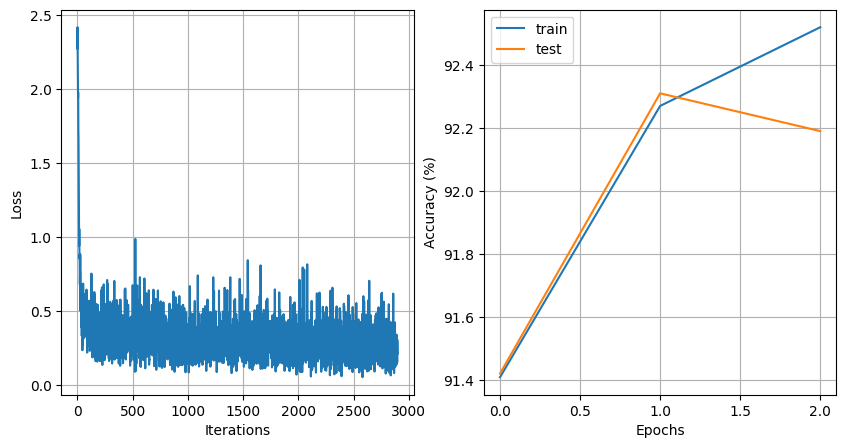

In [9]:
import matplotlib.pyplot as plt

# Assuming 'train_losses' is a list of tensors
train_losses_detached = [loss.detach().numpy() for loss in train_losses]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(train_losses_detached)  # Use the detached list of numpy arrays
plt.grid()

# Assuming you have additional plots or other code to follow
plt.subplot(1,2,2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.plot(train_accs, label = 'train')
plt.plot(test_accs, label = 'test')
plt.legend()
plt.grid()
